In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from pathlib import Path
import pandas as pd
import pyarrow.parquet as pq
import numpy as np


sns.set_theme(rc={'grid.linewidth': 0.6, 'grid.color': 'white',
                  'axes.linewidth': 2, 'axes.facecolor': '#ECECEC', 
                  'axes.labelcolor': '#000000',
                  'figure.facecolor': 'white',
                  'xtick.color': '#000000', 'ytick.color': '#000000'})

In [2]:
path_project = str(Path('__file__').absolute().parent)

## I. Training / tuning

Visualising tuning results for both tuned and default models.

In [3]:
optim_results = pd.read_excel(f'{path_project}\\model\\cv_results.xlsx')
optim_results = optim_results.rename(columns={'Unnamed: 0': 'model_type'})

optim_results['Lower'] = optim_results['rmse_avg'] - optim_results['rmse_std']
optim_results['Upper'] = optim_results['rmse_avg'] + optim_results['rmse_std']

optim_results = optim_results.sort_values(by='model_type')

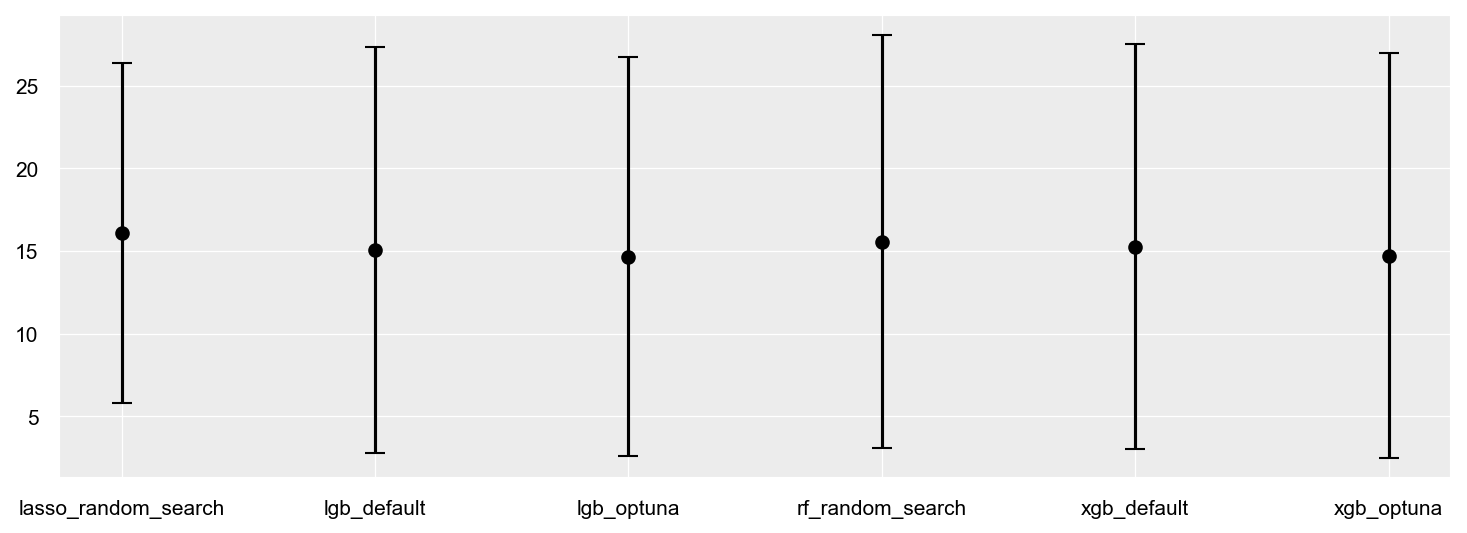

In [4]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    ax_flat[0].errorbar(optim_results['model_type'], optim_results['rmse_avg'], 
                        yerr=[optim_results['rmse_avg'] - optim_results['Lower'], 
                              optim_results['Upper'] - optim_results['rmse_avg']], 
                        fmt='o', color='black', capsize=5)
    
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

In [5]:
optim_results.round(2)

,model_type,rmse_avg,rmse_std,Lower,Upper
5,lasso_random_search,16.08,10.28,5.80,26.35
2,lgb_default,15.05,12.27,2.78,27.32
3,lgb_optuna,14.66,12.08,2.58,26.74
4,rf_random_search,15.56,12.49,3.06,28.05
0,xgb_default,15.26,12.25,3.01,27.51
1,xgb_optuna,14.72,12.25,2.47,26.98


## II. Testing

### 1. RMSE test set

Analysis of overall the test error for tuned and default models.

In [4]:
with open(f'{path_project}\\data\\forecast.parquet', 'rb') as handle:
    data = pq.read_table(handle).to_pandas()

data['squared_error'] = (data['pm25_median_forecast'] - data['pm25_median'])**2

In [7]:
# Avg rmse
err_model = data.groupby(['tuning', 'model'], as_index=False)['squared_error'].mean()
err_model['rmse'] = err_model['squared_error']**(1/2)

# Std
err_model_version = data.groupby(['tuning', 'model', 'fc_version'], 
                                 as_index=False)['squared_error'].mean()
err_model_version['rmse'] = err_model_version['squared_error']**(1/2)

err_model_version_std = err_model_version.groupby(['tuning', 'model'], as_index=False)['rmse'].std()
err_model_version_std = err_model_version_std.rename(columns={'rmse': 'rmse_std'})

err_model = err_model.merge(err_model_version_std, how='left', on=['tuning', 'model'])


def model_type(model, tuning):
    if tuning == 'False':
        return 'default'
    elif (model == 'xgb') or (model == 'lgb'):
        return 'optuna'
    else:
        return 'random_search'


# Model type
err_model['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in 
                           zip(err_model['model'], err_model['tuning'])]

err_model['Lower'] = err_model['rmse'] - err_model['rmse_std']
err_model['Upper'] = err_model['rmse'] + err_model['rmse_std']

err_model = err_model.sort_values(by='model_type')

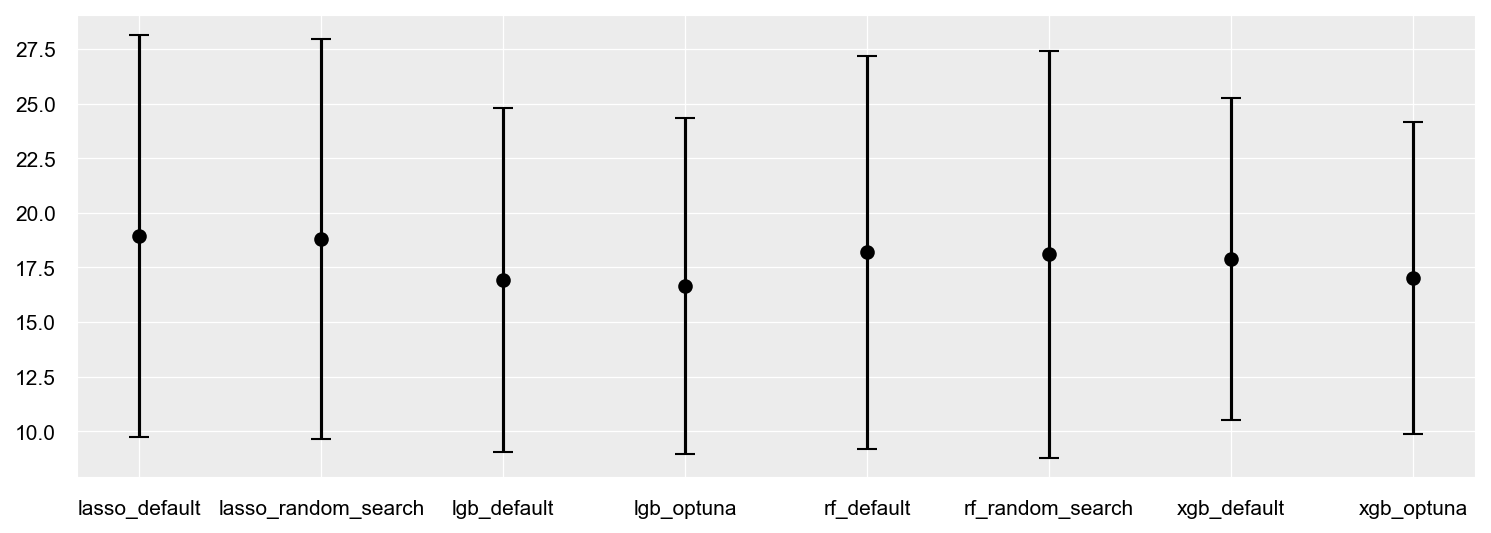

In [8]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    ax_flat[0].errorbar(err_model['model_type'], err_model['rmse'], 
                        yerr=[err_model['rmse'] - err_model['Lower'], 
                              err_model['Upper'] - err_model['rmse']], 
                        fmt='o', color='black', capsize=5)
    
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

In [9]:
err_model[['model_type', 'rmse', 'rmse_std', 'Lower', 'Upper']].round(2)

,model_type,rmse,rmse_std,Lower,Upper
0,lasso_default,18.93,9.20,9.74,28.13
4,lasso_random_search,18.82,9.15,9.66,27.97
1,lgb_default,16.91,7.87,9.05,24.78
5,lgb_optuna,16.64,7.70,8.94,24.34
2,rf_default,18.19,8.98,9.21,27.18
6,rf_random_search,18.10,9.32,8.77,27.42
3,xgb_default,17.88,7.37,10.51,25.25
7,xgb_optuna,17.01,7.14,9.88,24.15


### 2. RMSE test set (by day)

Analysis of the test error broken down by day for tuned and default models.

In [10]:
err_model_day = data.groupby(['tuning', 'model', 'day_number'], 
                             as_index=False)['squared_error'].mean()
err_model_day['rmse'] = err_model_day['squared_error']**(1/2)

err_model_day['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in 
                               zip(err_model_day['model'], err_model_day['tuning'])]

err_model_day = err_model_day.sort_values(by='model_type')

In [11]:
pd.pivot_table(err_model_day, index=['model_type'], columns='day_number', values='rmse').round(2)

day_number,0,1,2,3,4,5,6
model_type,,,,,,,
lasso_default,11.09,12.59,12.45,11.11,40.60,12.00,12.21
lasso_random_search,10.70,12.99,12.44,10.90,39.85,12.34,13.19
lgb_default,9.75,11.16,10.27,10.00,35.89,11.77,12.03
lgb_optuna,9.36,11.10,10.55,10.24,35.13,11.41,11.90
rf_default,13.06,11.63,10.97,9.98,39.06,10.96,11.74
rf_random_search,9.71,11.78,11.27,9.82,39.77,10.96,11.29
xgb_default,9.86,10.94,12.07,11.71,36.94,13.13,13.93
xgb_optuna,9.65,12.04,11.37,10.76,34.97,12.26,12.78


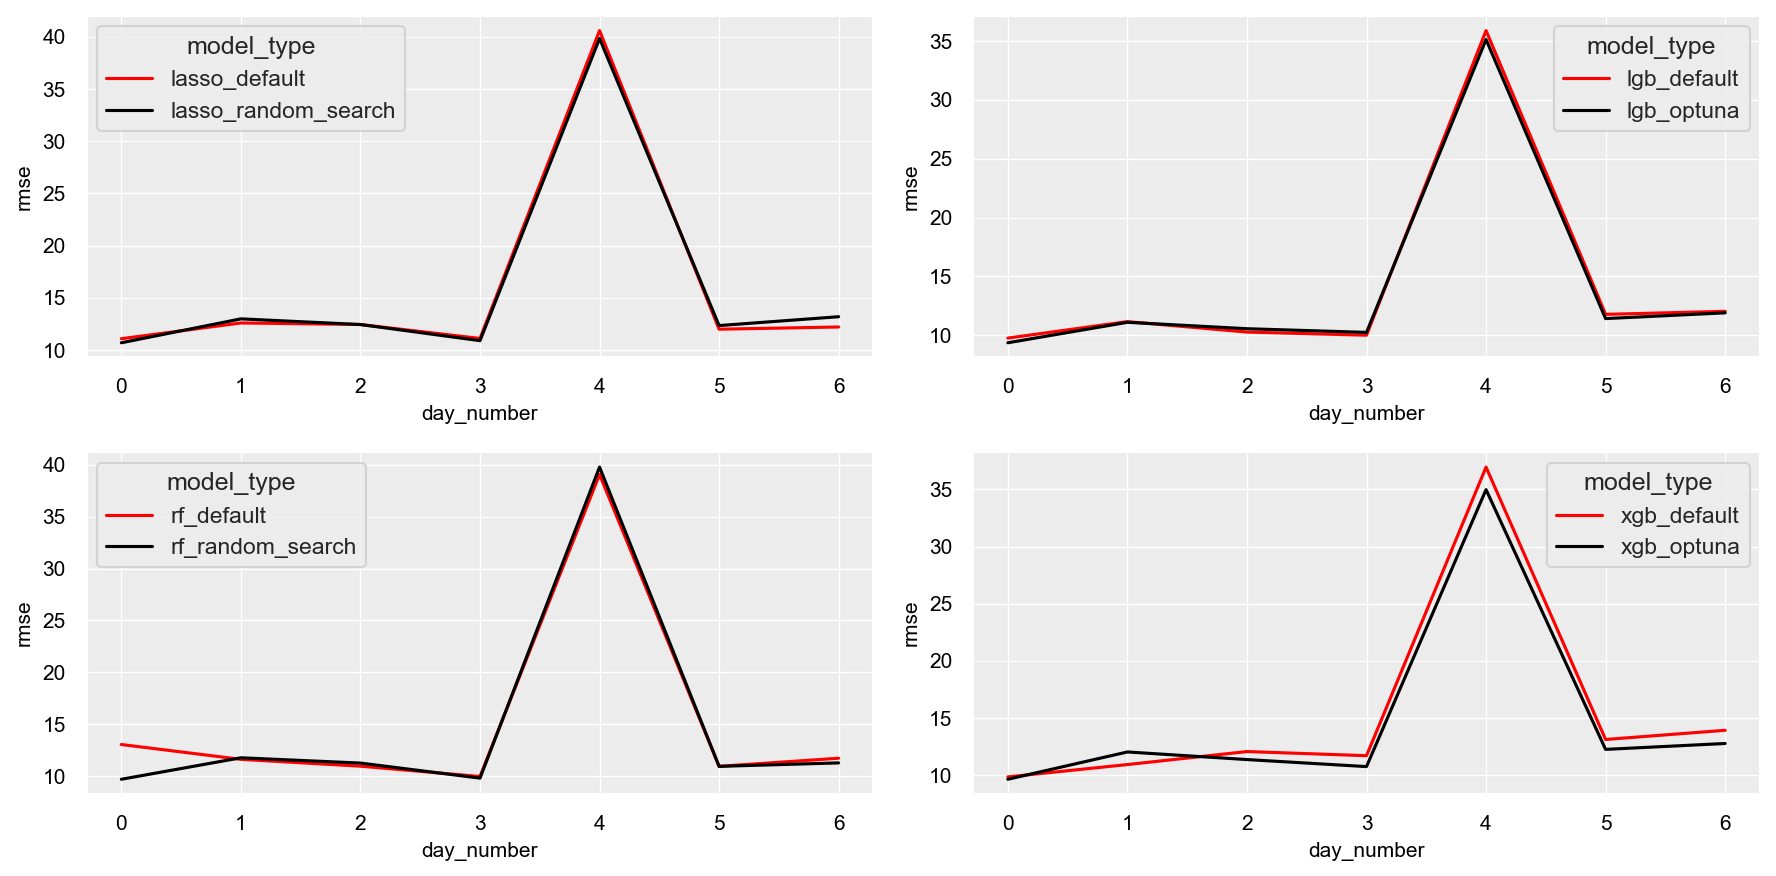

In [12]:
model_types = [err_model_day['model_type'].unique()[x:x+2] for x in range(0, 8, 2)]

with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 2, figsize = (12, 6))
    ax_flat = axes.flatten()

    for models, ax in zip(model_types, ax_flat):
        df = err_model_day[err_model_day['model_type'].isin(models)]
        sns.lineplot(ax=ax, x=df['day_number'], palette=['#FF0000', '#000000'],
                     y=df['rmse'], hue=df['model_type'])

plt.tight_layout()
plt.show()

### 3. RMSE test set (exclude spikes)

Analysis of the test error with 2 days (spikes) out of 56 excluded for tuned and default models.

In [18]:
# Avg rmse
err_model_day = data[~data['Date'].isin(['2020-11-09', '2020-12-09'])].groupby(['tuning', 'model'], 
                     as_index=False)['squared_error'].mean()

err_model_day['rmse'] = err_model_day['squared_error']**(1/2)

# Std
err_model_version = data[~data['Date'].isin(['2020-11-09', '2020-12-09'])].groupby(['tuning', 'model', 'fc_version'], 
                         as_index=False)['squared_error'].mean()

err_model_version['rmse'] = err_model_version['squared_error']**(1/2)
err_model_day_std = err_model_version.groupby(['tuning', 'model'], as_index=False)['rmse'].std()
err_model_day_std = err_model_day_std.rename(columns={'rmse': 'rmse_std'})

err_model_day = err_model_day.merge(err_model_day_std, how='left', on=['tuning', 'model'])

# Model type
err_model_day['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in 
                               zip(err_model_day['model'], err_model_day['tuning'])]

err_model_day = err_model_day.sort_values(by='model_type')

err_model_day

,tuning,model,squared_error,rmse,rmse_std,model_type
0,False,lasso,140.850618,11.868050,0.974838,lasso_default
4,True,lasso,145.515483,12.062980,1.147007,lasso_random_search
1,False,lgb,120.192847,10.963250,0.458315,lgb_default
5,True,lgb,118.540620,10.887636,0.497411,lgb_optuna
2,False,rf,129.437973,11.377081,1.530240,rf_default
6,True,rf,117.961316,10.861000,0.949426,rf_random_search
3,False,xgb,152.103250,12.333015,1.049623,xgb_default
7,True,xgb,137.321739,11.718436,1.317044,xgb_optuna


### 4. Forecast test set (total)

In [14]:
data['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in zip(data['model'], data['tuning'])]
data_gr = data[data['tuning'] == 'True'].groupby(['Date', 'model_type'], 
                                                 as_index=False)[['pm25_median_forecast', 'pm25_median']].sum()

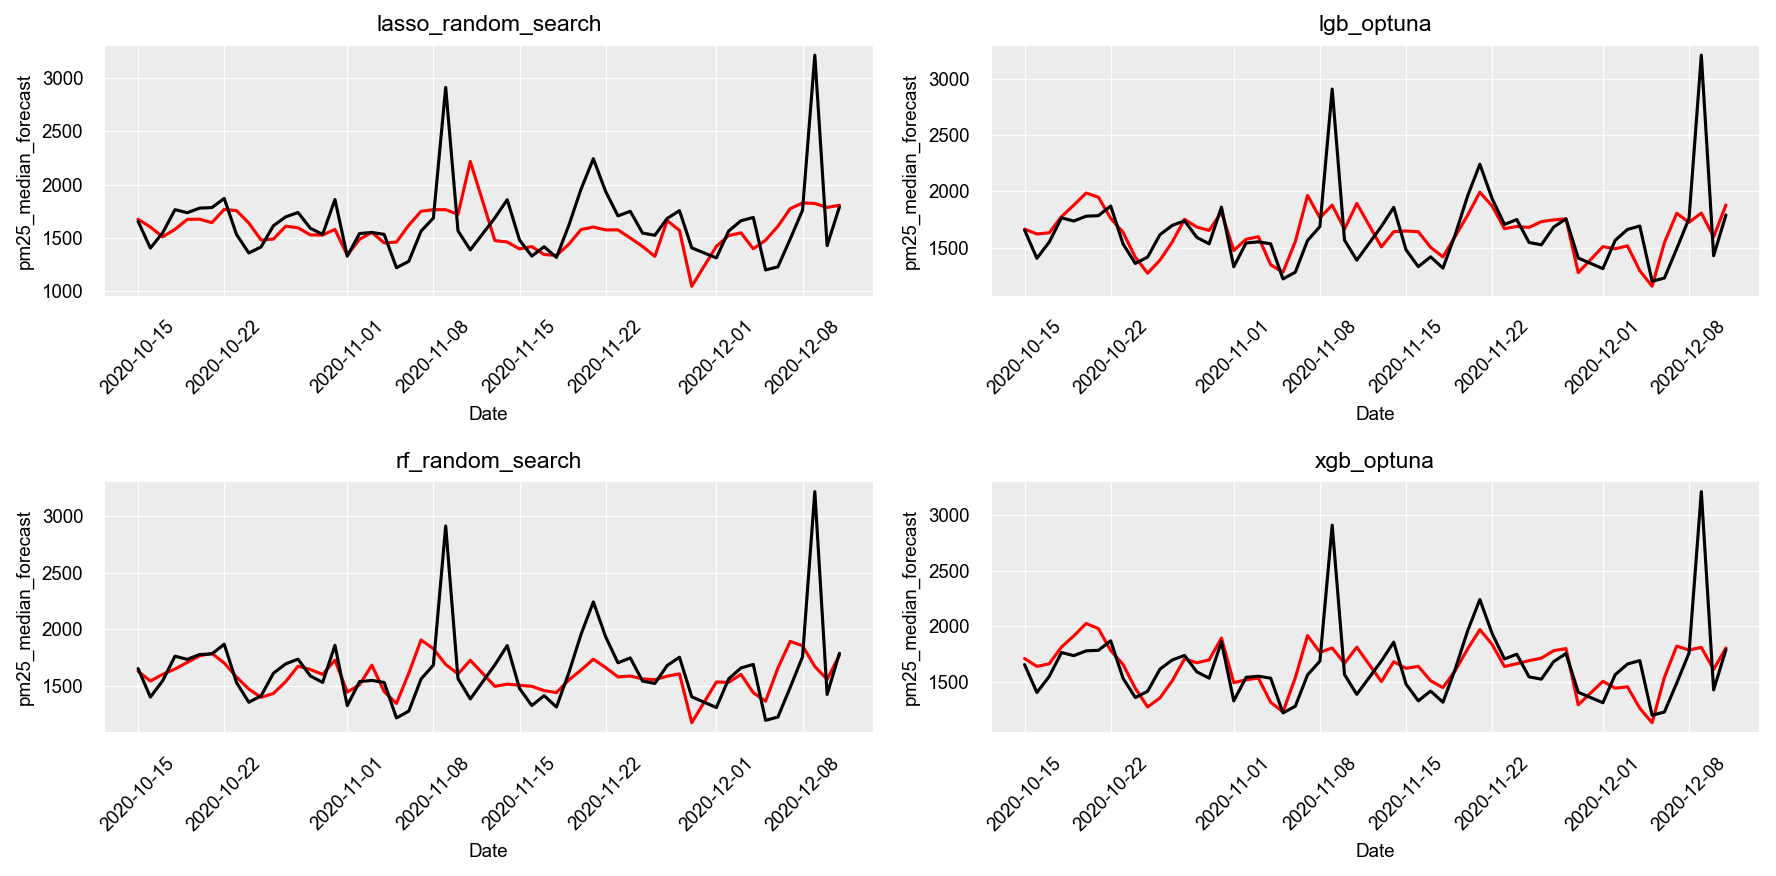

In [15]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}):
    
    fig, axes = plt.subplots(2, 2, figsize = (12, 6))
    ax_flat = axes.flatten()

    for model, ax in zip(data_gr['model_type'].unique(), ax_flat):
        df = data_gr[data_gr['model_type'] == model]
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median_forecast'], color='red')
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median'], color='black')

        ax.set_title(str(model), fontsize=11, color='black')
        plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

In [16]:
data_gr = data.groupby(['Date', 'day_number', 'model_type'], as_index=False)[['pm25_median_forecast', 'pm25_median']].sum()
data_gr = data_gr[data_gr['model_type'] == 'lgb_optuna']

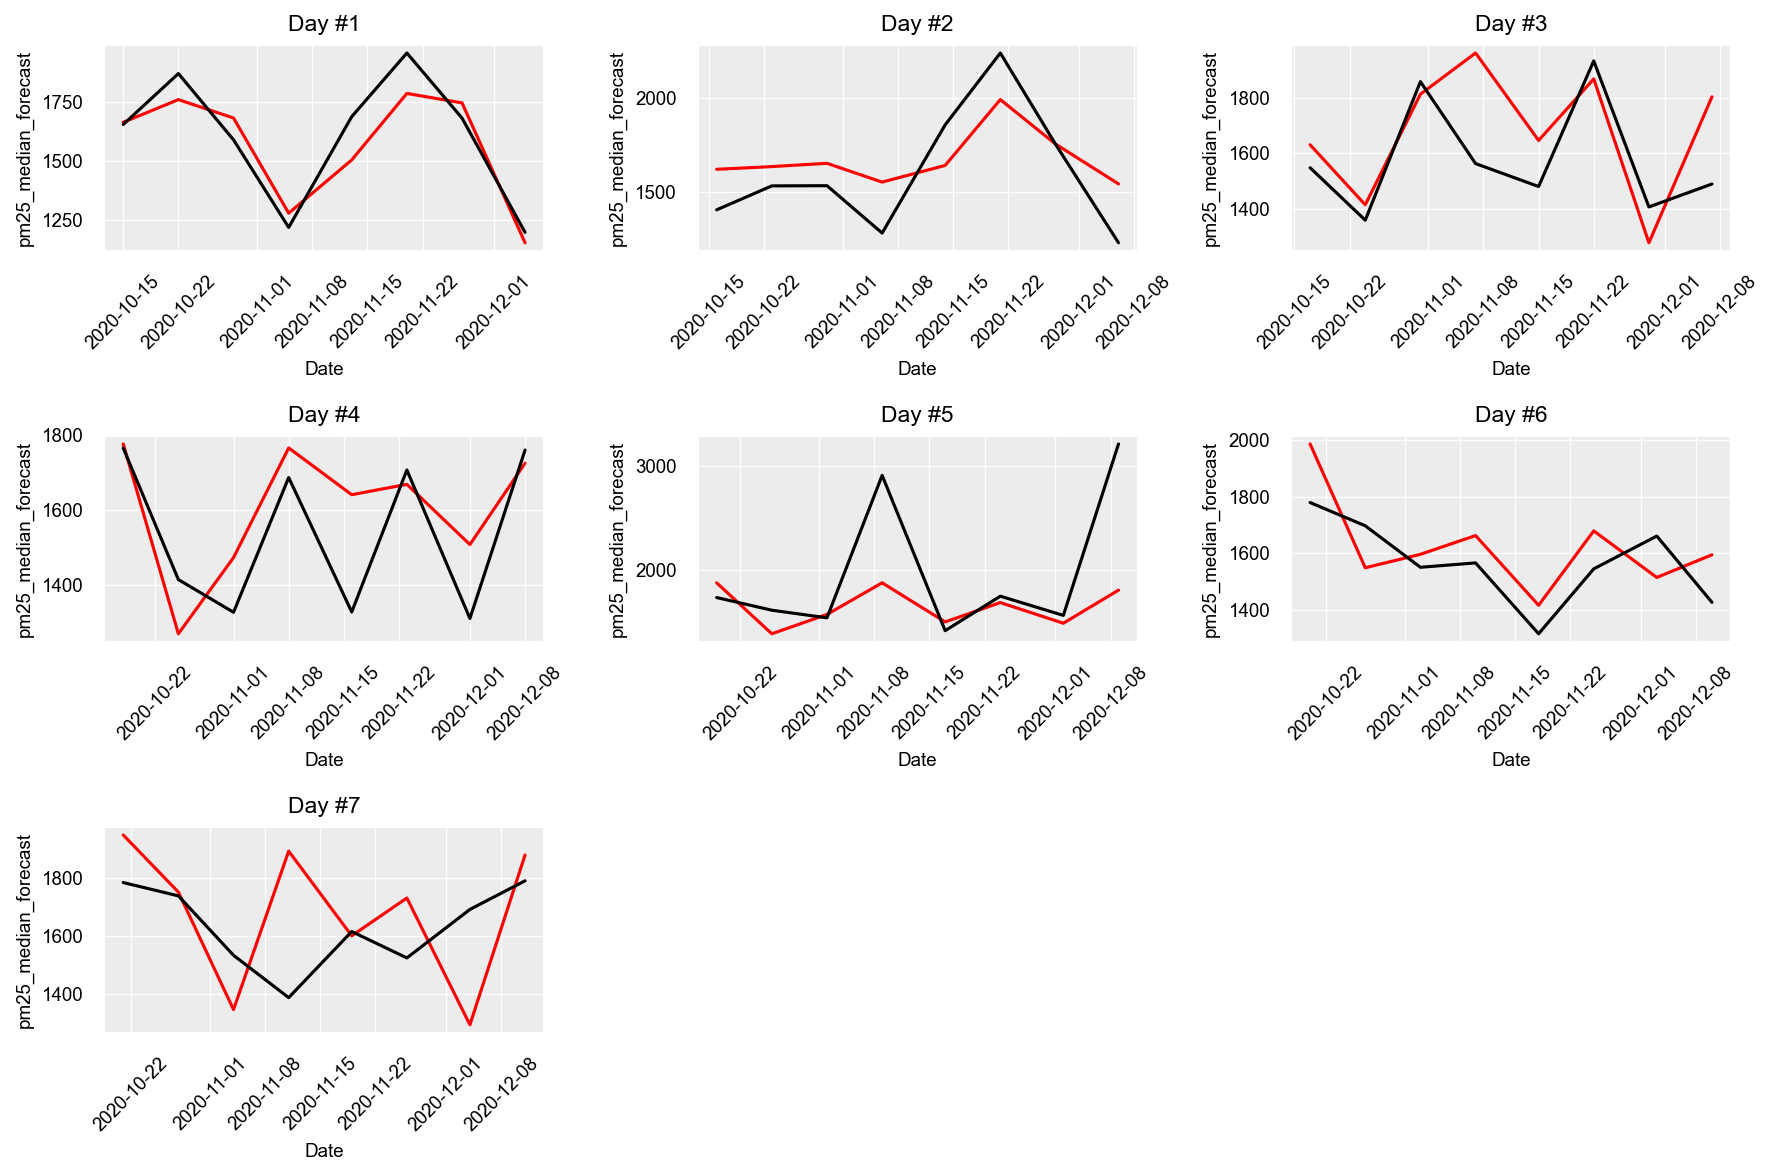

In [17]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}):
    
    fig, axes = plt.subplots(3, 3, figsize = (12, 8))
    ax_flat = axes.flatten()

    for idx, (day, ax) in enumerate(zip(data_gr['day_number'].unique(), ax_flat)):
        df = data_gr[data_gr['day_number'] == day]
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median_forecast'], color='red')
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median'], color='black')

        ax.set_title(f'Day #{day + 1}', fontsize=11, color='black')
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    # Removing empty figures
    [axes.set_visible(False) for axes in ax_flat[idx + 1:]]

plt.tight_layout()
plt.show()

### 5. Forecast test set (by city)

In [69]:
data['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in zip(data['model'], data['tuning'])]
data_gr = data[data['model_type'] == 'lgb_optuna'].groupby(['Date', 'City'], 
               as_index=False)[['pm25_median_forecast', 'pm25_median']].sum()

data_gr = data_gr[data_gr['City'].isin(data_gr['City'].unique()[0:8])]

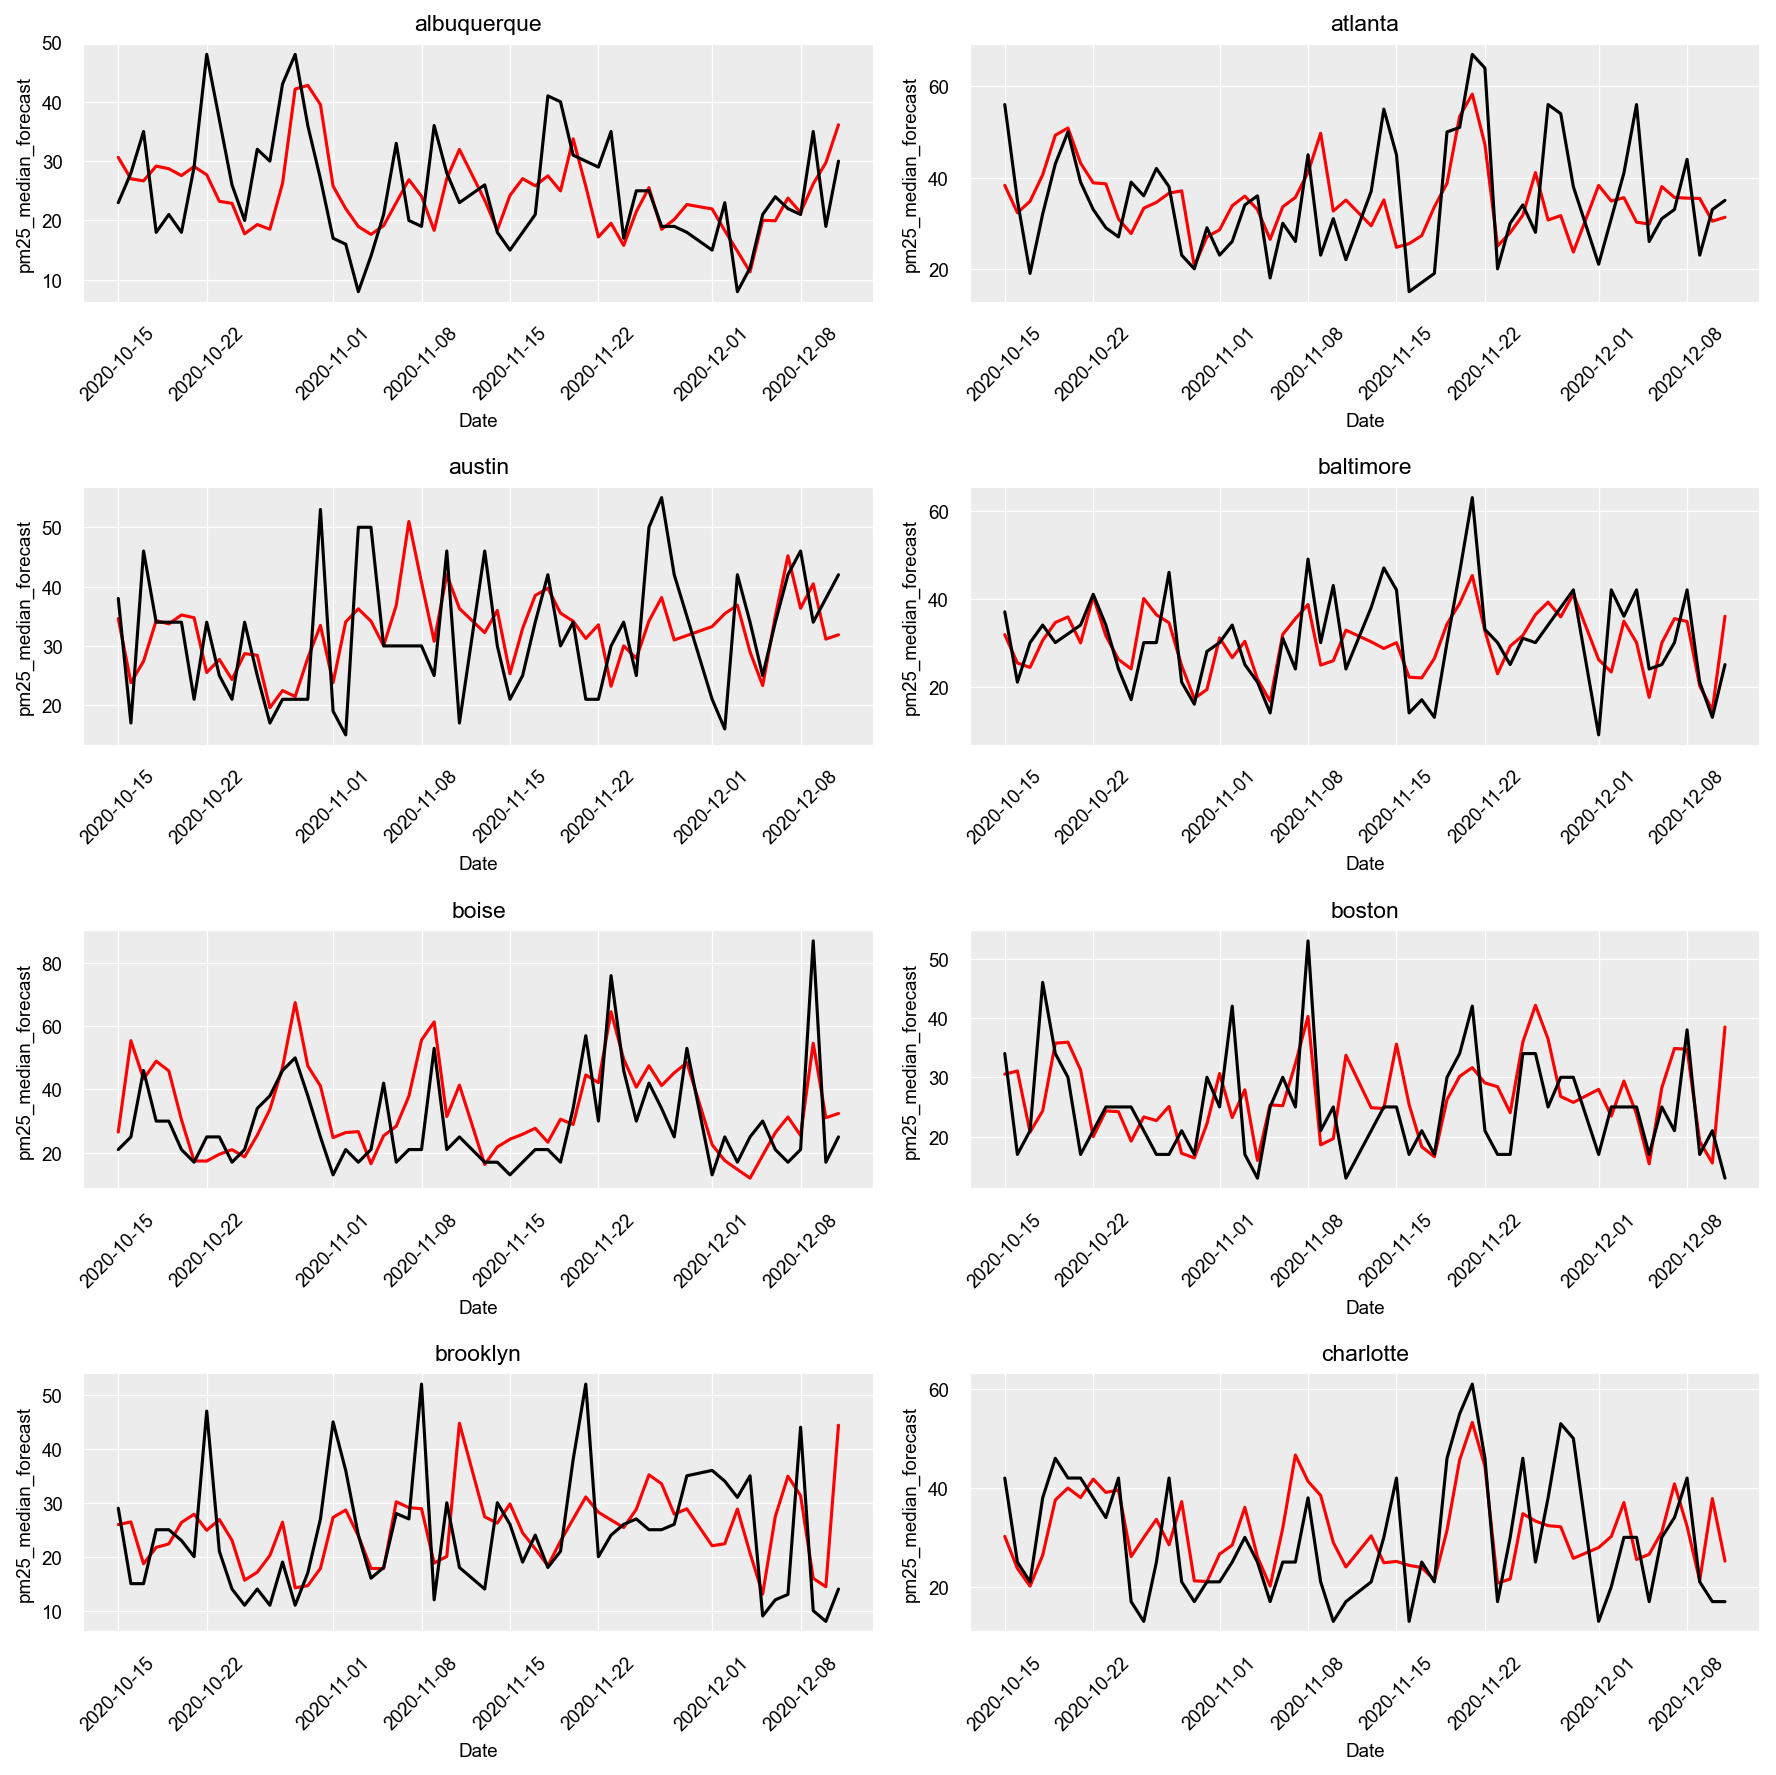

In [70]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}):
    
    fig, axes = plt.subplots(4, 2, figsize = (12, 12))
    ax_flat = axes.flatten()

    for model, ax in zip(data_gr['City'].unique(), ax_flat):
        df = data_gr[data_gr['City'] == model]
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median_forecast'], color='red')
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median'], color='black')

        ax.set_title(str(model), fontsize=11, color='black')
        plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()